In [1]:
# python standard library
import random
import copy
import csv
import string
import math
from collections import defaultdict
import platform
import pkg_resources
# packages
import numpy as np
import scipy as sp
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import networkx as nx
import graphviz

print("python", " "*(20-len("python")), platform.python_version())

modules = ["numpy", "scipy", "matplotlib", "networkx", "graphviz"]

for module in modules:
    print(module, " "*(20-len(module)), pkg_resources.get_distribution(module).version)

python                3.7.3
numpy                 1.16.4
scipy                 1.3.0
matplotlib            3.1.0
networkx              2.3
graphviz              0.12


### Introduction

The 7-bag randomizer algorithm presents the 7 pieces in a random order, and then repeats. This is typically implemented as something analogous to a list which is literally shuffled every 7 pieces. Shuffling is a well-studied problem with known efficient algorithms such as the [Fisher-Yates shuffle](https://en.wikipedia.org/wiki/Fisher%E2%80%93Yates_shuffle). For small scales such as 7-bag's mere $7! = 5040$ possible permutations, you could even pre-compute all shuffles and then simply select bags at random.

The 7-bag randomizer has many desirable properties. The maximum piece drought size has an upper limit of 12, which is generally seen as a positive thing. However it comes at a cost: 7-bag is the lowest entropy randomizer algorithm to ever appear in a commercial Tetris game. Certain aspects of 7-bag are particularly controversial, such as the possibility of players use degenerate [card counting](https://en.wikipedia.org/wiki/Card_counting) strategies. Examples include a single-player solution that allows [playing forever](https://tetris.wiki/Playing_forever). Another is the use of [perfect clear openers](https://harddrop.com/wiki/Perfect_Clear_Opener) in competitive settings. Many people feel that card counting is not a fun/interesting skill and these strategies take away from the core improvisational appeal of the game.

This notebook explores an alternative implementation of the 7-bag algorithm as a Markov process. While this is computationally less efficient, it provides a new perspective on the algorithm which facilitates some interesting modifications. In particular, the Markov process is simplified by removing the bag index state and increasing the entropy, reducing the viability of card-counting strategies. This is done in a way that exactly preserves the distribution of expected piece drought intervals. The net result is an algorithm with higher entropy and which feels very similar except for the absence of card counting. Additional randomizer constructions are explored, sharing many essential features of 7-bag while increasingly deviating from it in order to further increase entropy and reduce the viability of degenerate strategies.


### Representation

My chosen representation of the randomizer state includes:

- the current bag index
- an ordered list of the 7 current drought interval sizes (increasing order)
- a mapping of each of the 7 piece types to their respective drought interval size

The bag index simply keeps track of how many elements have been removed from the bag. The first selection has 0 removed, meaning the will be 7 branching options. Next there are 6 branching options, etc.

The ordered list allows convenient indexing for piece selection. If you are at bag index $n$, then the first $n$ options (the smallest droughts ie. the most recently received pieces) are unavailable.  

The mapping is extra bookkeeping to translate from the ordered list to an actual piece type. It is only needed if you actually want to deal pieces (ie. implement this in a game). As I'm only interested in studying the randomizer's drought interval and entropy properties, adding this is unneccessary and it will not be included in the randomizer state.

In [2]:
class State7Bag:
    'Holds the state of a 7-bag randomizer.'

    def __init__(self, bag_index=0, droughts=[x for x in range(7)]):
        self.bag_index = bag_index
        self.droughts = droughts

    def __str__(self):
        return "Randomizer State: " + str(self.__dict__)

    def name(self):
        return "Index = " + str(self.bag_index) + ",\nDroughts =\n" + str(
            self.droughts)

    def __deepcopy__(self, memo):
        return State7Bag(
            copy.deepcopy(self.bag_index, memo),
            copy.deepcopy(self.droughts, memo))

    def __hash__(self):
        return hash((self.bag_index, tuple(self.droughts)))

    def __eq__(self, other):
        return self.bag_index == other.bag_index and self.droughts == other.droughts

While it is possible to represent Markov systems as a matrix, our Markov system here is sparsely connected. At each transition, there are just 1 to 7 possible transitions (depending on the bag index). As there are many MANY more states than 7, this would result in an extremely [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix). For this reason, rather than using a matrix I chose to use a [directed graph](https://en.wikipedia.org/wiki/Directed_graph) which is more practical for sparsely connected systems, especially as the number of states increases as in more complicated randomizer constructions. 

In our Markov system each node corresponds to a unique randomizer state as defined above, and each edges corresponds to a certain "pick", ie. which element of the drought-ordered list was selected. Note that by definition, for 7-bag each pick maps onto a unique drought size, whereas for different randomizers with different states this is not necessarily the case.

At the beginning of each bag, the state is always:  

```Randomizer State: {'bag_index': 0, 'droughts': [0, 1, 2, 3, 4, 5, 6]}```

To give an example with a couple loops around the bag:

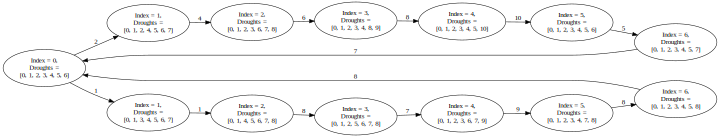

In [3]:
demo = nx.DiGraph()
old_state = State7Bag()

for i in range(2 * 7):
    roll = random.randrange(old_state.bag_index, 7)
    new_state = copy.deepcopy(old_state)
    new_state.bag_index = (new_state.bag_index + 1) % 7
    selection = new_state.droughts[roll]
    new_state.droughts = [drought + 1 for drought in new_state.droughts]
    new_state.droughts[roll] = 0
    new_state.droughts.sort()
    demo.add_edge(
        old_state,
        new_state,
        weight=1 / (7 - old_state.bag_index),
        drought=selection)
    old_state = copy.deepcopy(new_state)


def plot_graph(graph):
    viz = graphviz.Digraph()
    viz.attr(rankdir='LR', size='10')
    viz.attr('node', shape='oval')
    for from_node, to_node in graph.edges():
        viz.edge(
            from_node.name(),
            to_node.name(),
            label=str(graph.edges[from_node, to_node]['drought']))
    return viz


plot_graph(demo)

The numbers above the egdes represent the drought interval produced by the selected piece, and the drought list in the nodes represents a running total (ie. just a lower bound as opposed to the final/actualized droughts). You will note that after each selection there is a piece with a drought of 0, the most recently selected piece. The other drought intervals all grow larger by one.

### Full Contruction

The above graph illustrates just 2 possible trajectories through the 7-bag randomizer. There are far too many states to plot graphically, and it's probably best to systematically step through all the branching options systematically instead of randomly selecting them. So lets step through everything and see exactly what we're dealing with.

In [4]:
B7 = nx.DiGraph()
state_set = set()
state_work = list()

old_state = State7Bag()
state_work.append(old_state)

while len(state_work) > 0:
    # manage work queue
    old_state = copy.deepcopy(state_work[0])
    state_work.pop(0)
    state_set.add(old_state)
    # explore state transitions
    for roll in range(old_state.bag_index, 7):
        new_state = copy.deepcopy(old_state)
        new_state.bag_index += 1
        if (new_state.bag_index == 7):
            new_state.bag_index = 0
        drought = new_state.droughts[roll]
        new_state.droughts = [drought + 1 for drought in new_state.droughts]
        new_state.droughts[roll] = 0
        new_state.droughts.sort()
        B7.add_edge(
            old_state,
            new_state,
            drought=drought,
            pick=roll,
            weight=1 / (7 - old_state.bag_index))
        if (new_state not in state_set) and (new_state not in state_work):
            state_work.append(new_state)

print("Number of randomizer states (nodes):", len(B7))
print("Number of state transitions (edges):", len(B7.edges()))

Number of randomizer states (nodes): 127
Number of state transitions (edges): 448


That's a lot of nodes and edges! In matrix representation, we would expect it to be just $(1 - \frac{448}{127^2}) \approx 97\%$ empty.

### Summary Statistics

Randomizer algorithms can be extremely varied and feel dramatically different from one another. Humans intuit these differences through experience, but these abstract feelings can be tricky to communicate. It is useful to build a common language to help express the ways these randomizers differ. In an attempt to do this, clever Tetris enthusiasts have invented countless summary statistics, many of them partially overlapping in function. Rather than explore every last summary statistic variation, here I'm just focusing on my personal favourites which I believe succinctly capture much of the character of a randomizer.

* **Drought Curve**: Shows the percent of the time you should expect to be droughted for exactly $x$ pieces. A repeat is a drought of size 0.
* **Entropy**: A percentage value that expresses how close a randomizer is to being pure random.
* **Periodic Components**: Confirms whether there are cyclical patterns, like drawing from bags without replacement and then refilling the bag every $n$ pieces.
* **Permutation Components**: Confirms whether all piece types are treated the same, or else which groups of pieces receive equal treatment.
 
The remainder of this section more explicitly defines what these are and how calculate them from a randomizer's graph representation.

#### Finding the stationary distribution

In the context of a specific randomizer state, it is pretty straightforward to directly calculate a statistic of interest. Say, the probability of your next piece being a duplicate of the previous piece. But when we're summarizing a randomizer's behaviour we care about the global properties of the algorithm. Even if we repeat the calculation for every possible randomizer state, it's not entirely clear how to best compress this into an overall summary: some of the states are surely more common/rarer than others. What we need to know is the percent of the time a randomizer spends in each state, which would allow us to take a weighted average of the statistic across all the states.

Fortunately, this is a well studied problem. A randomizer's migration from state to state can be described by a [Markov chain](https://en.wikipedia.org/wiki/Markov_chain). The long run proportion of the time spent in each state is better known as the Markov chain's *stationary distribution*. Given a Markov transition matrix $M$, a stationary distribution vector $v$ has the property:

$$vM = v$$

If you remember your linear algebra, you can see that $v$ is an [eigenvector](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors) of eigenvalue 1. Finding this eigenvector is a pre-requisite to calculating other interesting randomizer statistics. We will lean on SciPy's [sparse.linalg.eigs()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigs.html) to solve for it using [Arnoldi iteration](https://en.wikipedia.org/wiki/Arnoldi_iteration).

In [5]:
def get_eigenvector(G):

    # when there's only one state it crashes linalg.eigs()
    if len(G) == 1:
        return dict(zip(G, [1.0]))

    # obtain and normalize the eigenvector
    M = nx.to_scipy_sparse_matrix(G, nodelist=G, weight='weight')
    eigenvalue, eigenvector = sp.sparse.linalg.eigs(M.T, k=1, which='LR')
    eigenvector = eigenvector.flatten().real
    eigenvector = eigenvector / eigenvector.sum()

    return dict(zip(G, eigenvector))

#### Drought Curve

A drought size is defined as the number of pieces generated between sequential occurences of a particular piece. If you get the same piece twice in a row, that's a drought of size 0. The drought curve is a plot which illustrates the probability $y$ of getting a drought of exactly size $x$. In other words, this is the [probability mass function](https://en.wikipedia.org/wiki/Probability_mass_function) of drought sizes, which is essentially a [hazard rate](https://en.wikipedia.org/wiki/Survival_analysis#Hazard_function_and_cumulative_hazard_function) on the "survival" of a drought.
  
  **insert plot demo**
  
Though drought sizes are discrete which would typically be plotted using a variant of a bar plot, they are presented here as line plots with markers as this makes it easier to compare multiple drought distributions at once. This is mentioned simply as a warning to make sure you don't mistake them for a [density function](https://en.wikipedia.org/wiki/Probability_density_function) (which is continuous) and start expecting them to integrate to 1. Instead, the marker $y$ values should sum to 1.

My approach to calculating the drought distribution is just a bit of simple (if tedious) bookkepping. I'll let the code speak for itself.

In [6]:
def get_edges(G, from_node=None):
    if from_node is None:
        if type(G) == nx.MultiDiGraph:
            return G.edges(keys=True)
        elif type(G) == nx.DiGraph:
            return G.edges()
    else:
        edge_list = []
        if type(G) == nx.MultiDiGraph:
            for to_node in G[from_node]:
                for key in G[from_node][to_node]:
                    edge_list.append((from_node, to_node, key))
        elif type(G) == nx.DiGraph:
            for to_node in G[from_node]:
                edge_list.append((from_node, to_node))
        return edge_list

In [7]:
def get_drought_dist(G, stable, drought_max=12):

    # start with weightings per the stationary distribution
    # also remember which pick index the piece of interest is in (starts at 0)
    vec = dict(((0, state), p) for state, p in stable.items())

    drought_dist = {}
    # consider only a bounded number of drought sizes (some randomizers have no upper limit)
    for drought in range(drought_max + 1):
        drought_dist[drought] = 0
        old_vec = copy.deepcopy(vec)
        vec = defaultdict(lambda: 0)

        # consider all drought pick + state combinations with non-zero weight
        for ext_state, p in old_vec.items():
            drought_pick, from_node = ext_state

            # consider all their branching picks
            for edge in get_edges(G, from_node):
                pick = G.edges[edge]['pick']
                weight = G.edges[edge]['weight']

                # send the weight to the drought distribution (we picked the right piece to end the drought)
                if pick == drought_pick:
                    drought_dist[drought] += p * weight
                    continue

                # update the new pick + state combination
                if pick < drought_pick:
                    new_ext_state = tuple((drought_pick, edge[1]))
                elif pick > drought_pick:
                    new_ext_state = tuple((drought_pick + 1, edge[1]))

                # move the weight to its new state
                vec[new_ext_state] += p * weight

    return drought_dist

#### Entropy

[Entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) quantifies how random/uncertain the next piece is on average. While entropy is commonly expressed in base 2 (ie. bits or "how many coin flips for this much randomness") here we use base 7 (ie. "how many pure random tetris pieces for this much randomness"). Doing it this way, the maximum entropy is 1. The lowest possible entropy is 0, which is achieved with any deterministic rule such as "always give the most droughted piece". In this way, the base 7 entropy can be interpreted as something analogous to the *% random* a given randomizer is.

In [8]:
def get_entropy(G, stable):
    entropy = 0
    for from_node, weight in stable.items():
        state_entropy = 0

        # within a state, pool by pick
        pick_weight = defaultdict(lambda: 0)
        for edge in get_edges(G, from_node):
            pick = G.edges[edge]['pick']
            pick_weight[pick] += G.edges[edge]['weight']

        # calculate the entropy accross picks
        for p in pick_weight.values():
            state_entropy += -p * math.log(p, 7)
        entropy += weight * state_entropy

    return entropy


def get_perplexity_dist(G, stable, future_max=12):

    # start with weightings per the stationary distribution
    # {(original state, current state, current order map): weight within original state}
    vec = dict(
        ((state, state, (0, 1, 2, 3, 4, 5, 6)), 1) for state in stable.keys())

    entropy_dist = defaultdict(lambda: 0)
    last_round = False
    # consider only a bounded number of future piece generations
    for future in range(future_max + 1):
        # swap work buffers
        old_vec, vec = vec, defaultdict(lambda: 0)
        pick_weight = defaultdict(lambda: [0]*7)
        # getting too big, stop early
        if len(old_vec) > 1000000 or future == future_max:
            last_round = True
        if len(old_vec) > 2000000:
            break
        print("Analyzing future", future, "with", len(old_vec), "states...")

        # consider all pick order + state combinations with non-zero weight
        for ext_state, p in old_vec.items():
            orig_state, from_node, piece_order = ext_state

            # consider all their branching picks
            for edge in get_edges(G, from_node):

                # pool weight by original state and pick weight
                pick = G.edges[edge]['pick']
                orig_pick = piece_order[pick]
                weight = p * G.edges[edge]['weight']
                pick_weight[orig_state][orig_pick] += weight

                # create next work list with appropriate weight
                if last_round == False:
                    new_piece_order = []
                    new_piece_order.append(piece_order[pick])
                    for i in [x for x in range(7) if x != pick]:
                        new_piece_order.append(piece_order[i])
                    new_piece_order = tuple(new_piece_order)
                    vec[(orig_state, edge[1], new_piece_order)] += weight

        # calculate the entropy from pooled pick weights
        for state, picks in pick_weight.items():
            entropy = 0
            weight = stable[state]
            for p in [x for x in picks if x > 0]:
                entropy += (-p * math.log(p, 7))
            entropy_dist[future] += pow(7, entropy) * weight
        print("Entropy:", entropy_dist[future])

        # entropy is monotonic and can't exceed 1
        if math.isclose(entropy_dist[future], 7, rel_tol=1e-3):
            for i in range(future+1, future_max+1):
                entropy_dist[i] = 7
            break
        # flat entropy must stay flat
        elif future > 0 and math.isclose(entropy_dist[future], entropy_dist[future - 1]):
            for i in range(future+1, future_max+1):
                entropy_dist[i] = entropy_dist[future]
            break
        elif last_round == True:
            break

    return entropy_dist

#### Periodic Components

This captures cyclical patterns. Picture someone who never breaks their routine, choosing from 2 cereals for breakfast, 3 salads for lunch, and 10 restaurants for dinner. You can't predict exactly what is being eaten in the future, but if they are eating lunch now you know 3 meals from now they will eat lunch again. Followed by dinner. There can even be patterns like never eating the same meal 2 days in a row, or the same restaurant twice in a week -- this all fits into patters of period length 3.

More formally this captures the [periodicity](https://en.wikipedia.org/wiki/Markov_chain#Periodicity) of the randomizer. A randomizer with period length $p$ can partition its states into $p$ periodic components. A randomizer cycles through the components in a fixed order. After generating $n$ pieces, the randomizer is guaranteed to be in a state belonging to component $n \bmod p$. The $p$ is chosen as the greatest common divisor (gcd) of all possible cycles. 
  
    
  **insert illustration**
 
If the period length is 1, then the randomizer is considered *aperiodic* and there are no cyclical patterns. Otherwise, there are cyclical patterns in the generated sequences which will to an extent be responsible for a decrease in entropy. At worst these can be strong patterns which greatly decrease the entropy (eg. bags and card counting strategies). However, it also is possible for subtler patterns to exist (eg. the NES randomizer with bitwise logic introducing biases on an 8-period).

#### Permutation Components

With a randomizer written out in code, it is easy to see if the piece types are all treated the same: You can just read the algorithm and see if it discriminates based on piece type. With graph representations this transparency is lost -- it's quite possible to have a graph which gives special treatment to one or more piece types but it's non-trivial to manually sift through a pile of graph data to figure out if and how those biases exist. This is what motivated building a systematic way to map this out.

This captures whether the randomizer treats piece types differently. Piece types are partitioned into permutation components. Within each component, all piece types are treated the same way in the randomizer logic. To give an example of something that would have multiple components, Tetris World's square mode uses a memoryless randomizer that suppresses the probability of Z and S pieces (they are less useful for building 4x4 squares). This randomizer therefore has 2 permutation components {Z, S} and {J, I, L, O, T}.

More formally, if a permutation component has $n$ piece types then for every randomizer state it must be possible to identify which $n$ elements of the ordered piece list map (perhaps ambiguously) onto those $n$ piece types. For each permutation component there can be no strict subset which also also meets this condition. ie. You should use this rule to divide the piece types into as many components as possible.
  
  **insert piece list -> pick, permutation group, possible pieces**
  
Note that as a randomizer iterates the evolution of the mapping permutation is stochastic rather than cyclic, so the use of [cycle notation](https://en.wikipedia.org/wiki/Permutation#Cycle_notation) is not appropriate. Cycle notation can only describe the permutation behaviour of a individual cycles within the graph, whereas the permutation components summarize the possibilities over all possible paths.
    
If a randomizer has just 1 component -- and all the popular randomizers do -- then a randomzier is considered *type invariant* with all permutations of the mapping being possible in every state. This also implies that in the long run all piece types occur in equal proportions. It should be noted that the converse is not true: it is possible for randomizers with more than 1 permutation component to generate piece types in equal long run proportions.

### Verification

We should check to make sure this representation of 7-bag is correct. Let's see if we can recreate a known emergent quality of 7-bag, the symmetric pyramid drought interval distribution. This requires 2 steps:

- Calculate the stable state of the Markov system, giving us the % of the time the randomizer will be at each node (ie. the normalized [eigenvector](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors) of eigenvalue 1)
- Iterate over all the edges, grouping by drought interval and summing the stable proportion times the branching probability

Since each edge is equal to a particular drought value, we can simply sum all the weighted branching probabilities to get the overall drought interval distribution. In addition to visually inspecting the distribution, we can also do a sanity check that the drought interval probabilities sum to 1.

Another important thing to check is the entropy of the alorithm, this is known to be:

$-\sum \limits_{i=1}^7 \frac{1}{7} \times \log_7(\frac{1}{i}) \approx 62.59\%$

Analyzing future 0 with 127 states...
Entropy: 4.000000000000018
Analyzing future 1 with 448 states...
Entropy: 4.857142857142874
Analyzing future 2 with 1393 states...
Entropy: 5.571428571428584
Analyzing future 3 with 3948 states...
Entropy: 6.142857142857146
Analyzing future 4 with 11382 states...
Entropy: 6.571428571428571
Analyzing future 5 with 38220 states...
Entropy: 6.857142857142844
Analyzing future 6 with 141330 states...
Entropy: 6.999999999999986


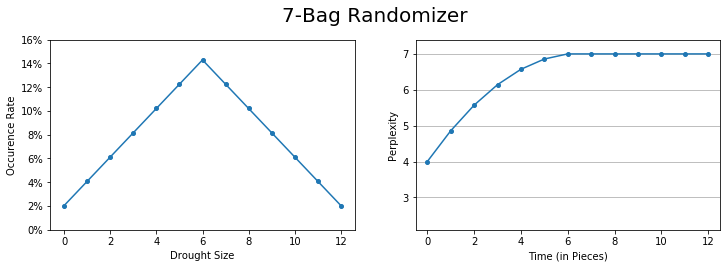

Number of randomizer states (nodes): 127
Number of state transitions (edges): 448
Sum of drought interval probabilities:  100.0 %
Entropy (Base 7):  62.59 %



In [9]:
def plot_counter(name, drought, perplexity):
    
    from matplotlib.ticker import FuncFormatter
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3.5))
    fig.suptitle(name + " Randomizer", fontsize=20, y=1.01)
    
    x = [x for x in range(len(drought))]
    y = [y for y in drought.values()]
    ax1.plot(x, y, marker='o', markersize=4)
    ax1.set_ylim(bottom=0, top=round(max(y) + 0.015, 2))
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
    ax1.set_xlabel("Drought Size")
    ax1.set_ylabel("Occurence Rate")
    
    x = [x for x in range(len(perplexity))]
    y = [y for y in perplexity.values()]
    ax2.plot(x, y, marker='o', markersize=4)
    ax2.set_xlim([-0.5, 12.5])
    ax2.set_ylim([2.1, 7.4])
    ax2.yaxis.grid(True)
    ax2.set_xlabel("Time (in Pieces)")
    ax2.set_ylabel("Perplexity")
    
    plt.show()


def rand_report(G, name, save=False):
    
#     G = fold_graph(G)
    
    stable = get_eigenvector(G)
    drought_dist = get_drought_dist(G, stable)
    perplexity_dist = get_perplexity_dist(G, stable, future_max = 12)
    entropy = get_entropy(G, stable)
    
    plot_counter(name, drought_dist, perplexity_dist)

    print("Number of randomizer states (nodes):", len(G))
    print("Number of state transitions (edges):", len(G.edges()))
    print("Sum of drought interval probabilities: ",
          round(100 * sum(drought_dist.values()), 2), "%")
    print("Entropy (Base 7): ", round(100 * entropy, 2), "%")
#     print("Future Information: ", round(len(entropy_dist)*7 - sum(entropy_dist.values()), 4), "Pieces")
    print()

    if save == True:
        write_rand(G, name)


rand_report(B7, "7-Bag")

Everything checks out! We've got a working graph-based implementation of 7-bag. Time to explore some variations!

### Seamless 7-bag

My first idea is to remove the bag index from the state of the randomizer, but to do it in a way that preserves the probability of branching through a certain drought selection. In theory this should result in no change at all to the expected drought distribution, giving a randomizer that feels very close to 7-bag without actually suffering from card counting issues. However, what we should notice is an increase in entropy since there is less structure to the randomness.

Analyzing future 0 with 64 states...
Entropy: 4.462087174987756
Analyzing future 1 with 256 states...
Entropy: 5.581350583312979
Analyzing future 2 with 991 states...
Entropy: 6.290484735312098
Analyzing future 3 with 3823 states...
Entropy: 6.682940051981783
Analyzing future 4 with 14831 states...
Entropy: 6.858809148095954
Analyzing future 5 with 56369 states...
Entropy: 6.917234517492017
Analyzing future 6 with 200187 states...
Entropy: 6.935651074362983
Analyzing future 7 with 635943 states...
Entropy: 6.956998831266463
Analyzing future 8 with 1773875 states...
Entropy: 6.972747178556449


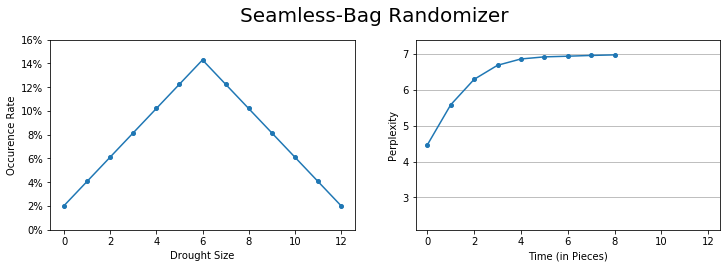

Number of randomizer states (nodes): 64
Number of state transitions (edges): 256
Sum of drought interval probabilities:  100.0 %
Entropy (Base 7):  72.17 %



In [10]:
def remove_index(graph):
    stable = get_eigenvector(graph)
    new_graph = nx.DiGraph()
    
    # assign new weights to the simpler graph
    for from_node, to_node in graph.edges():
        base_prob = stable[from_node]
        branch_prob = graph.edges[from_node, to_node]['weight']
        drought = graph.edges[from_node, to_node]['drought']
        pick = graph.edges[from_node, to_node]['pick']

        # make the new state simply an ordered list of droughts
        new_from_node = tuple(from_node.droughts)
        new_to_node = tuple(to_node.droughts)
        
        # weight the branch probability according to the stable state proportion
        weight = base_prob * branch_prob
        
        # if something is already branching there, include that weight also
        if new_graph.has_edge(new_from_node, new_to_node):
            weight += new_graph.edges[new_from_node, new_to_node]['weight']
        
        # add new edge, overwritting if it already exists
        new_graph.add_edge(new_from_node, new_to_node, weight=weight, drought=drought, pick=pick)

    # renormalize the weights to sum to 1
    for from_node in new_graph:
        denominator = 0
        for to_node in nx.neighbors(new_graph, from_node):
            denominator += new_graph.edges[from_node, to_node]['weight']
        for to_node in nx.neighbors(new_graph, from_node):
            new_graph.edges[from_node, to_node]['weight'] /= denominator
    
    return new_graph

Seamless_B7 = copy.deepcopy(B7)
Seamless_B7 = remove_index(B7)
rand_report(Seamless_B7, "Seamless-Bag")

Entropy increases all while the interval curve stays the same, just as predicted. Interestingly, this moves entropy 10% closer to pure random! That's going from having the lowest entropy of any published Tetris game, to being less than random than TGM1 but more random than TGM2 or TGM3.

### Generic Randomizer File Format

This code takes a randomizer graph and turns it into a generic randomizer. It's just a CSV with 3 columns:

* Probability of branching (integer with implied denominator of $12!$)
* Pick index from the list of droughted pieces (increasing order)
* The row of the CSV to jump to, corresponding to a new node / randomizer state

Row 0 is specifically chosen to be the most common state of the graph.

Analyzing future 0 with 64 states...
Entropy: 4.4620871749877535
Analyzing future 1 with 256 states...
Entropy: 5.581350583312977
Analyzing future 2 with 991 states...
Entropy: 6.290484735312099
Analyzing future 3 with 3823 states...
Entropy: 6.6829400519817845
Analyzing future 4 with 14831 states...
Entropy: 6.858809148095953
Analyzing future 5 with 56369 states...
Entropy: 6.917234517492019
Analyzing future 6 with 200187 states...
Entropy: 6.935651074362985
Analyzing future 7 with 635943 states...
Entropy: 6.95699883126646
Analyzing future 8 with 1773875 states...
Entropy: 6.97274717855645


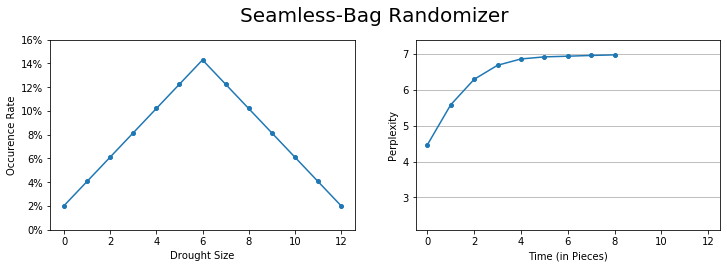

Number of randomizer states (nodes): 64
Number of state transitions (edges): 256
Sum of drought interval probabilities:  100.0 %
Entropy (Base 7):  72.17 %



In [11]:
def write_rand(graph, name):
    edge_list = list(graph.edges())
    edge_list.sort()
    node2index = dict()
    previous_from_node = None
    if type(graph) == nx.MultiDiGraph:
        i = 0
        for from_node, to_node, key, weight in graph.edges(keys=True):
            if from_node != previous_from_node:
                previous_from_node = from_node
                node2index[from_node] = i
            i += 1
    elif type(graph) == nx.DiGraph:
        for i, edge in enumerate(edge_list):
            if edge[0] != previous_from_node:
                previous_from_node = edge[0]
                node2index[edge[0]] = i

    # pick a large denominator with many factors
    denominator = math.factorial(12)

    weights = []
    picks = []
    jumps = []
    if type(graph) == nx.MultiDiGraph:
        for from_node, to_node, key in graph.edges(keys=True):
            weight = int(round(weight * denominator, 0))
            pick = graph.edges[from_node, to_node, key]['pick']
            jump = node2index[to_node]
            weights.append(weight)
            picks.append(pick)
            jumps.append(jump)
    elif type(graph) == nx.DiGraph:
        for i, edge in enumerate(edge_list):
            weight = int(round(graph.edges[edge]['weight'] * denominator, 0))
            pick = graph.edges[edge]['pick']
            jump = node2index[edge[1]]
            weights.append(weight)
            picks.append(pick)
            jumps.append(jump)

    # adjust weights, compensating for rounding errors, so that they sum up to the denominator
    nodes = list(node2index.values())
    nodes.append(len(edge_list))
    nodes.sort()
    for i in range(len(nodes) - 1):
        start = nodes[i]
        stop = nodes[i + 1]
        adjustment = denominator - sum(weights[start:stop])
        node_weights = weights[start:stop]
        target = np.argmax(node_weights)
        weights[start + target] += adjustment

    # save the file
    filename = ''.join([name, '.rng'])
    with open(filename, 'w', newline='') as csvfile:
        rand_writer = csv.writer(csvfile, delimiter=',')
        for i in range(len(edge_list)):
            weight = str(weights[i])
            pick = str(picks[i])
            jump = str(jumps[i])
            rand_writer.writerow([weight, pick, jump])


rand_report(Seamless_B7, "Seamless-Bag", save=True)

This code uses the randomizer file to create the specified randomizer.

For initialization, the inital piece map is random and the randomizer state corresponds to row 0 of the CSV.

For piece generation, the generic randomizer keeps track of the piece mapping and steps through the randomzier states per the CSV rules defined above. The piece mapping is simply logic keeping track of an ordered list of most recently to least recently received pieces.

In [12]:
class LoadRandomizer:
    def __init__(self, name):
        """Creates a randomizer from a an .rng file matching the randomizer name."""
        self.piece_map = ['J', 'I', 'Z', 'L', 'O', 'S', 'T']
        self.order = [0, 1, 2, 3, 4, 5, 6]
        random.shuffle(self.order)
        self.state_i = 0
        self.denominator = math.factorial(12)
        self.randomizer = []
        filename = ''.join([name, '.rng'])
        with open(filename, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            for row in reader:
                weight = int(row[0])
                pick = int(row[1])
                jump = int(row[2])
                self.randomizer.append([weight, pick, jump])

    def next_piece(self):
        """Generate a new piece given the randomizer state."""
        roll = random.randrange(1, self.denominator + 1)
        while roll > self.randomizer[self.state_i][0]:
            roll -= self.randomizer[self.state_i][0]
            self.state_i += 1
        pick_index = self.randomizer[self.state_i][1]
        self.state_i = self.randomizer[self.state_i][2]
        pick_piece = self.order[pick_index]
        for i in reversed(range(1, pick_index + 1)):
            self.order[i] = self.order[i - 1]
        self.order[0] = pick_piece
        return self.piece_map[pick_piece]

To test that the above is working, I created a helper function to Monte Carlo the drought distribution. 

Generating test sequence of length 1000000 ...
Sample:
LTSLTOZIJSZIOSJLTZSOIITLJSZTOLIOJIZTSLOTSIZJISLTOILZJSISOTIJZLOSOTILZJZOSTLIJZISJLOTZZSTJISZOLOLISZTJTOLSTJIOZSLIOJTLOZTJSIJSTZOLZOSJLTITOILZSJTLZIOSISLOTZJTLISOLTSZIJOZSTILLSTZOJLSILOTSJZTOLIOZTLSJIIOTZJISLSZLJTOIZJLSTITLZJOILSLZJTIOLSLOITJZZJILOSTJSIOZLITOSLJOSTLZISJSLITOZZTILOJSTJIZOLZJTSZLOJISTJLZOIZJTLSZSJOILTZOSIJTOSLZOSJISLOZTZIJTOLSLSZTILJOOJSZILTJOSLZTISOTZIJLSJOLTJSIZLOTZJSILJIZTLSOITJLZSOIITSZLJIOTOZJLISLSTZOJLILTZSJOIJTZLOSSLIZJOTSLJITLZSOZTLJILZTSOIOTJZOSILIOJZSTJSIZOLZIJSTSLOJTZIJOIZSTLJIOTSZJLTJILZOJTISZSTOJILZLITJOSOTSLZJISJZOLTLZISJOLITLZIJSOZSILTIJITLSZOIJZOSTL


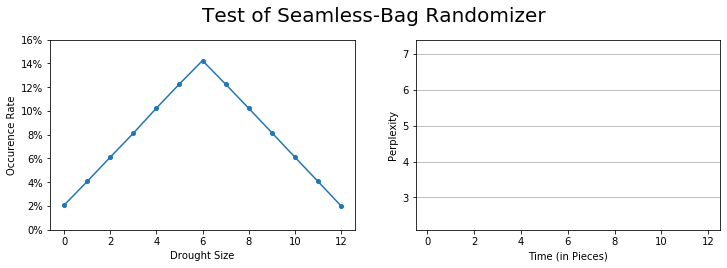

In [13]:
def test_rand(name, n=1000000):
    randomizer = LoadRandomizer(name)
    test_sequence = []
    print("Generating test sequence of length", n, "...")
    for _ in range(n):
        test_sequence.append(randomizer.next_piece())
    print("Sample:")
    print(''.join(test_sequence[0:585]))

    droughts = dict()
    for i in range(13):
        droughts[i] = 0
    current_droughts = dict()
    pieces = "JIZLOST"
    for piece in pieces:
        current_droughts[piece] = 0

    for selection in test_sequence:
        if current_droughts[selection] not in droughts:
            droughts[current_droughts[selection]] = 0
        droughts[current_droughts[selection]] += 1
        for piece in pieces:
            current_droughts[piece] += 1
        current_droughts[selection] = 0

    denominator = sum(droughts.values())
    for key in droughts:
        droughts[key] = droughts[key] / denominator
    plot_counter("Test of " + name, droughts, droughts)


test_rand("Seamless-Bag")

### Chaos 7-bag

Another interesting related randomizer to consider is one with even higher entropy. This one preserves the graph structure of seamless 7-bag, but changes the weights to maximize the entropy.

Naively you might expect maximum entropy when, for a given node, all the edges are equally likely. This is not the case but I will explore it first.

Analyzing future 0 with 64 states...
Entropy: 4.33939448101653
Analyzing future 1 with 256 states...
Entropy: 5.61057245363127
Analyzing future 2 with 991 states...
Entropy: 6.3858638118366775
Analyzing future 3 with 3823 states...
Entropy: 6.731951205250047
Analyzing future 4 with 14831 states...
Entropy: 6.845291144793711
Analyzing future 5 with 56369 states...
Entropy: 6.886749817989068
Analyzing future 6 with 200187 states...
Entropy: 6.914892200904458
Analyzing future 7 with 635943 states...
Entropy: 6.930779422522162
Analyzing future 8 with 1773875 states...
Entropy: 6.940232606898932


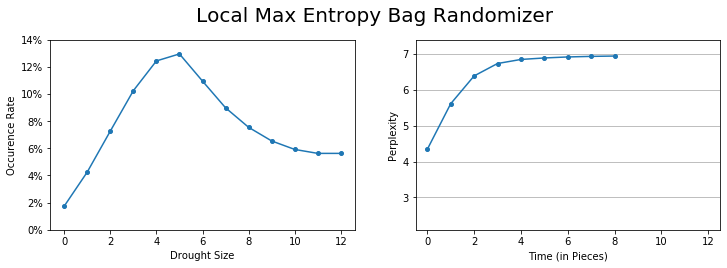

Number of randomizer states (nodes): 64
Number of state transitions (edges): 256
Sum of drought interval probabilities:  100.0 %
Entropy (Base 7):  70.07 %



In [14]:
def local_max_entropy(graph):
    for from_node in graph:
        denominator = 0
        for to_node in nx.neighbors(graph, from_node):
            denominator += 1
        for to_node in nx.neighbors(graph, from_node):
            graph.edges[from_node, to_node]['weight'] = 1 / denominator
    return graph


Chaos_7B = copy.deepcopy(Seamless_B7)
Chaos_7B = local_max_entropy(Chaos_7B)

rand_report(Chaos_7B, "Local Max Entropy Bag")

The problem with this is that it weights branches into low entropy states (ie. "dead ends") too heavily. So while entropy is locally maximized for a given state, the overall system has a resulting net decrease in entropy.

Fortunately there is an analytic approach to calculating the probability weights of the configuration of maximum entropy of the overall system.

$P_{ij} = \frac{M_{ij}}{\lambda} \times \frac{\psi_{j}}{\psi_{i}}$

Where:
* $P_{ij}$ is the branching probabilities from state $i$ to state $j$
* $M_{ij}$ is the adjacency matrix of the Markov system
* $\lambda$ is the principal eigenvalue of $M_{ij}$
* $\psi_{i}$ and $\psi_{j}$ are the *ith* and *jth* elements of $\lambda$'s eigenvector


Analyzing future 0 with 64 states...
Entropy: 4.534510104508119
Analyzing future 1 with 256 states...
Entropy: 5.757842587461429
Analyzing future 2 with 991 states...
Entropy: 6.464166167906003
Analyzing future 3 with 3823 states...
Entropy: 6.765175686307523
Analyzing future 4 with 14831 states...
Entropy: 6.869838999787448
Analyzing future 5 with 56369 states...
Entropy: 6.905210114768688
Analyzing future 6 with 200187 states...
Entropy: 6.920278160327415
Analyzing future 7 with 635943 states...
Entropy: 6.931904400597332
Analyzing future 8 with 1773875 states...
Entropy: 6.948766250852008


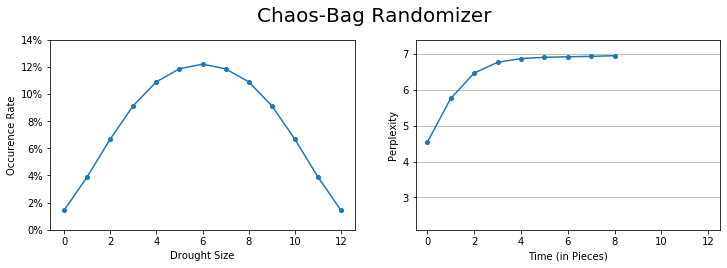

Number of randomizer states (nodes): 64
Number of state transitions (edges): 256
Sum of drought interval probabilities:  100.0 %
Entropy (Base 7):  74.24 %



In [15]:
def global_max_entropy(graph):
    nodelist = list(graph)
    M = nx.to_scipy_sparse_matrix(
        graph, nodelist=nodelist, weight='weight', dtype=float)
    M.data = np.ones(M.nnz)

    eigenvalue, eigenvector = sp.sparse.linalg.eigs(M, k=1, which='LR')
    eigenvalue = eigenvalue.flatten().real
    eigenvector = eigenvector.flatten().real

    for i in range(M.shape[0]):
        for ind in range(M.indptr[i], M.indptr[i + 1]):
            j = M.indices[ind]
            weight = (M[i, j] * eigenvector[j]) / (eigenvalue * eigenvector[i])
            weight = np.asscalar(weight)
            from_node = nodelist[i]
            to_node = nodelist[j]
            graph.edges[from_node, to_node]['weight'] = weight

    return graph

Chaos_7B = copy.deepcopy(Seamless_B7)
Chaos_7B = global_max_entropy(Chaos_7B)

rand_report(Chaos_7B, "Chaos-Bag", save=True)

### Beyond the 7-bag graph

Even without a bag index, and with maximized entropy, the adjacency matrix of 7-bag imposes a great deal of structure on the resulting sequences. For example, it is possible to receive a piece twice in a row but not 3 times in a row.

Below I explore the full possibility of all possible sequences without breaching a parameterized maximum allowed drought size.

Analyzing future 0 with 924 states...
Entropy: 5.610442199913789
Analyzing future 1 with 3696 states...
Entropy: 5.599223735096105
Analyzing future 2 with 15540 states...
Entropy: 5.600949585772284
Analyzing future 3 with 62286 states...
Entropy: 5.619933085543543
Analyzing future 4 with 239274 states...
Entropy: 5.65513234066824
Analyzing future 5 with 882301 states...
Entropy: 5.703754288999026


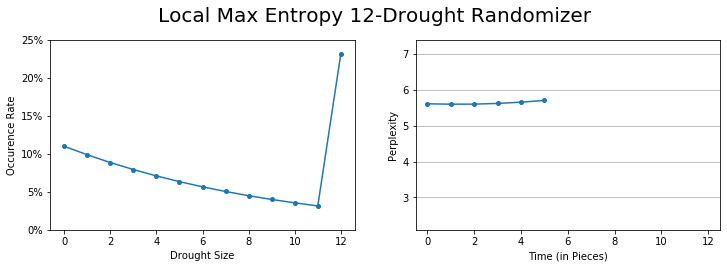

Number of randomizer states (nodes): 924
Number of state transitions (edges): 3696
Sum of drought interval probabilities:  100.0 %
Entropy (Base 7):  76.84 %

Analyzing future 0 with 924 states...
Entropy: 5.684454422470437
Analyzing future 1 with 3696 states...
Entropy: 6.038247925470758
Analyzing future 2 with 15540 states...
Entropy: 6.308206972525516
Analyzing future 3 with 62286 states...
Entropy: 6.492775032069808
Analyzing future 4 with 239274 states...
Entropy: 6.6167090910527335
Analyzing future 5 with 882301 states...
Entropy: 6.698974778217429


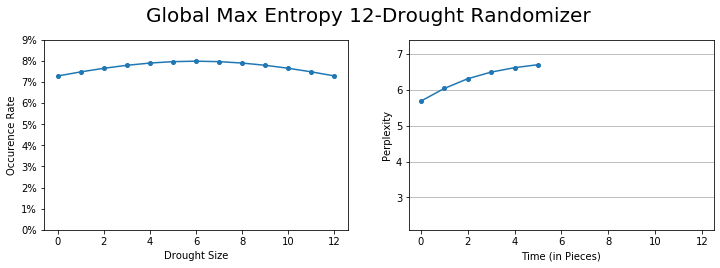

Number of randomizer states (nodes): 924
Number of state transitions (edges): 3696
Sum of drought interval probabilities:  100.0 %
Entropy (Base 7):  85.32 %



In [16]:
def full_graph(drought_max):
    graph = nx.DiGraph()
    state_set = set()
    state_work = list()

    old_state = tuple(range(7))
    state_work.append(old_state)

    while len(state_work) > 0:
        # manage work queue
        old_state = copy.deepcopy(state_work[0])
        state_work.pop(0)
        state_set.add(old_state)
        # explore state transitions
        for roll in range(7):
            new_state = [drought for drought in old_state]
            drought = new_state[roll]
            new_state = [drought + 1 for drought in new_state]
            new_state[roll] = 0
            new_state.sort()

            # detect forbidden state transitions
            if max(new_state) > drought_max:
                continue

            new_state = tuple(new_state)
            graph.add_edge(old_state, new_state, drought=drought, pick=roll)
            if (new_state not in state_set) and (new_state not in state_work):
                state_work.append(new_state)
    return graph


D12 = full_graph(drought_max=12)
D12 = local_max_entropy(D12)
rand_report(D12, "Local Max Entropy 12-Drought")
D12 = global_max_entropy(D12)
rand_report(D12, "Global Max Entropy 12-Drought")
write_rand(D12, "D12")

### A bunch of haphazard randomizer experiments

In [19]:
def remove_droughts(graph, forbidden):

    # remove edges matching drought criteria
    junk = []
    for from_node, to_node in graph.edges():
        drought = graph.edges[from_node, to_node]['drought']
        if drought in forbidden:
            junk.append((from_node, to_node))
            
    graph = remove_edges(graph, junk)
    return graph

def remove_edges(graph, junk_edges):
    # remove junk edges
    for from_node, to_node in junk_edges:
        graph.remove_edge(from_node, to_node)

    # remove any orphaned nodes if applicable
    connected = max(nx.strongly_connected_components(graph), key=len)
    junk_nodes = set()
    for node in graph:
        if node not in connected:
            junk_nodes.add(node)
    for node in junk_nodes:
        graph.remove_node(node)
        
    # re-weight
    for from_node in graph:
        denominator = 0
        for to_node in nx.neighbors(graph, from_node):
            denominator += graph.edges[from_node, to_node]['weight']
        for to_node in nx.neighbors(graph, from_node):
            graph.edges[from_node, to_node]['weight'] /= denominator

    return graph

Analyzing future 0 with 125 states...
Entropy: 3.4560830198152748
Analyzing future 1 with 374 states...
Entropy: 4.170368734100986
Analyzing future 2 with 986 states...
Entropy: 4.786026000243677
Analyzing future 3 with 2374 states...
Entropy: 5.273340550745459
Analyzing future 4 with 5907 states...
Entropy: 5.6370367192066055
Analyzing future 5 with 17666 states...
Entropy: 5.879072176209538
Analyzing future 6 with 58672 states...
Entropy: 5.999999999999942
Analyzing future 7 with 171734 states...
Entropy: 6.726766230191358
Analyzing future 8 with 430137 states...
Entropy: 6.86740977750704
Analyzing future 9 with 855380 states...
Entropy: 6.935583874135726
Analyzing future 10 with 1480221 states...
Entropy: 6.961772277695258


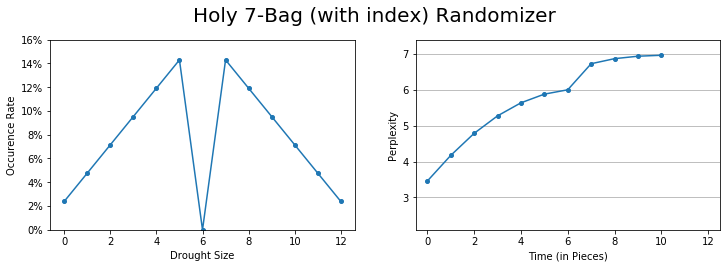

Number of randomizer states (nodes): 125
Number of state transitions (edges): 374
Sum of drought interval probabilities:  100.0 %
Entropy (Base 7):  55.24 %

Analyzing future 0 with 64 states...
Entropy: 3.851979758865441
Analyzing future 1 with 224 states...
Entropy: 4.8477399922557405
Analyzing future 2 with 781 states...
Entropy: 5.517643329178524
Analyzing future 3 with 2759 states...
Entropy: 5.893472663688599
Analyzing future 4 with 9774 states...
Entropy: 6.065456579978244
Analyzing future 5 with 33584 states...
Entropy: 6.133364260509818
Analyzing future 6 with 108080 states...
Entropy: 6.167410906052905
Analyzing future 7 with 318236 states...
Entropy: 6.748395233812832
Analyzing future 8 with 887892 states...
Entropy: 6.868744372418287


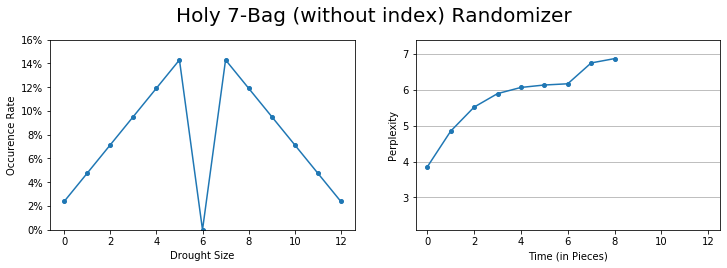

Number of randomizer states (nodes): 64
Number of state transitions (edges): 224
Sum of drought interval probabilities:  100.0 %
Entropy (Base 7):  65.02 %



In [20]:
test = copy.deepcopy(B7)
test = remove_droughts(test, [6])
test = global_max_entropy(test)
rand_report(test, "Holy 7-Bag (with index)")
test = remove_index(test)
rand_report(test, "Holy 7-Bag (without index)")
write_rand(test, "Holy-Bag")

Analyzing future 0 with 35 states...
Entropy: 2.592028863986953
Analyzing future 1 with 80 states...
Entropy: 2.6975920272122464
Analyzing future 2 with 179 states...
Entropy: 3.947231763186777
Analyzing future 3 with 405 states...
Entropy: 4.262780091249014
Analyzing future 4 with 952 states...
Entropy: 5.15188736019804
Analyzing future 5 with 2328 states...
Entropy: 5.4705030917143995
Analyzing future 6 with 5737 states...
Entropy: 5.873419356065789
Analyzing future 7 with 14204 states...
Entropy: 6.049295606551115
Analyzing future 8 with 32131 states...
Entropy: 6.159293908447191
Analyzing future 9 with 73892 states...
Entropy: 6.196555373619036
Analyzing future 10 with 151292 states...
Entropy: 6.318357941263534
Analyzing future 11 with 308037 states...
Entropy: 6.372764503936931
Analyzing future 12 with 558573 states...
Entropy: 6.483803603192389


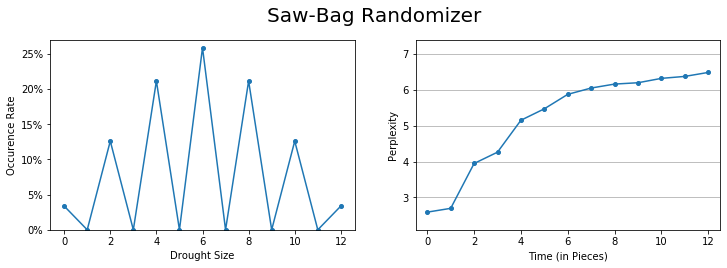

Number of randomizer states (nodes): 35
Number of state transitions (edges): 80
Sum of drought interval probabilities:  100.0 %
Entropy (Base 7):  45.96 %



In [21]:
saw_bag = copy.deepcopy(Seamless_B7)
saw_bag = remove_droughts(saw_bag, [1, 3, 5, 7, 9, 11])
saw_bag = global_max_entropy(saw_bag)
rand_report(saw_bag, "Saw-Bag", save=True)

In [22]:
def flat_droughts(graph):
    M = nx.to_scipy_sparse_matrix(
        graph, nodelist=list(graph), weight='weight', dtype=float)

    n_nodes = len(graph)
    n_edges = len(graph.edges())
    node_list = list(graph)
    index2edge = []
    index2drought = []
    for row in range(n_nodes):
        for i in range(M.indptr[row], M.indptr[row + 1]):
            col = M.indices[i]
            to_node = node_list[col]
            from_node = node_list[row]
            drought = graph.edges[from_node, to_node]['drought']
            index2edge.append([from_node, to_node])
            index2drought.append(drought)

    def vec2graph(x, prune=True):
        junk = []
        for i in range(n_edges):
            from_node = index2edge[i][0]
            to_node = index2edge[i][1]
            graph.edges[from_node, to_node]['weight'] = x[i]
            if int(round(x[i] * math.factorial(12), 0)) == 0:
                junk.append((from_node, to_node))
        if prune == True:
            remove_edges(graph, junk)
        return graph

    # function to minimize
    def flat(x):
        M.data = copy.deepcopy(x)
        eigenvalue, eigenvector = sp.sparse.linalg.eigs(M.T, k=1, which='LR')
        eigenvector = eigenvector.flatten().real
        eigenvector = eigenvector / eigenvector.sum()
        branch_weights = M.T.multiply(eigenvector)
    
        droughts = np.zeros(13)
        for i in range(len(x)):
            drought = index2drought[i]
            droughts[drought] += branch_weights.data[i]

        drought_entropy = 0
        for i in range(13):
            try:
                droughts[i] = -droughts[i] * math.log2(droughts[i])
            except ValueError:
                droughts[i] = 0
        drought_entropy = droughts.sum()
        
        return -drought_entropy

    # constraints
    constraints = []

    def ineq_constraint(x):
        """All edge weights must be >= 0."""
        return x

    constraints.append({'type': 'ineq', 'fun': ineq_constraint})

    def get_constraint(x, node):
        """All nodes must have edges whose weights sum to 1."""
        start = M.indptr[node]
        stop = M.indptr[node + 1]

        def prob_constraint(x):
            return np.sum(x[start:stop]) - 1

        return prob_constraint

    for i in range(n_nodes):
        constraint = get_constraint(M.data, i)
        constraints.append({'type': 'eq', 'fun': constraint})

    # perform the optimization given the constraints
    result = optimize.minimize(
        flat,
        M.data,
        method='SLSQP',
        constraints=constraints,
        options={'ftol': 1e-12})
    if result['success'] == False:
        for item in result:
            if item not in ['x', 'jac']:
                print(item, "=", result[item])
        print()

    return vec2graph(result['x'])

Analyzing future 0 with 64 states...
Entropy: 2.665912911304392
Analyzing future 1 with 255 states...
Entropy: 3.903954378371991
Analyzing future 2 with 978 states...
Entropy: 4.723288569563956
Analyzing future 3 with 3708 states...
Entropy: 5.290468631423919
Analyzing future 4 with 14028 states...
Entropy: 5.623060064920395
Analyzing future 5 with 51764 states...
Entropy: 5.888422632232355
Analyzing future 6 with 178323 states...
Entropy: 6.063066915728862
Analyzing future 7 with 556182 states...
Entropy: 6.188600214128079
Analyzing future 8 with 1549920 states...
Entropy: 6.292230894253421


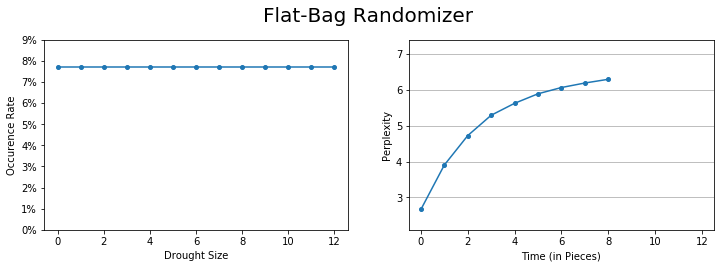

Number of randomizer states (nodes): 64
Number of state transitions (edges): 255
Sum of drought interval probabilities:  100.0 %
Entropy (Base 7):  47.66 %



In [23]:
flat_bag = copy.deepcopy(Seamless_B7)
flat_bag = flat_droughts(flat_bag)
rand_report(flat_bag, "Flat-Bag", save=True)

Analyzing future 0 with 6 states...
Entropy: 2.483389023750093
Analyzing future 1 with 12 states...
Entropy: 3.582490170708909
Analyzing future 2 with 26 states...
Entropy: 4.3576323870430675
Analyzing future 3 with 60 states...
Entropy: 4.79459476750453
Analyzing future 4 with 146 states...
Entropy: 4.962183119917103
Analyzing future 5 with 336 states...
Entropy: 5.7708180221318095
Analyzing future 6 with 782 states...
Entropy: 6.067169915991303
Analyzing future 7 with 1828 states...
Entropy: 6.163670516898895
Analyzing future 8 with 4122 states...
Entropy: 6.178336225532502
Analyzing future 9 with 8678 states...
Entropy: 6.191425832739885
Analyzing future 10 with 15618 states...
Entropy: 6.613813540441113
Analyzing future 11 with 25130 states...
Entropy: 6.6839873752077
Analyzing future 12 with 38550 states...
Entropy: 6.733353495355279


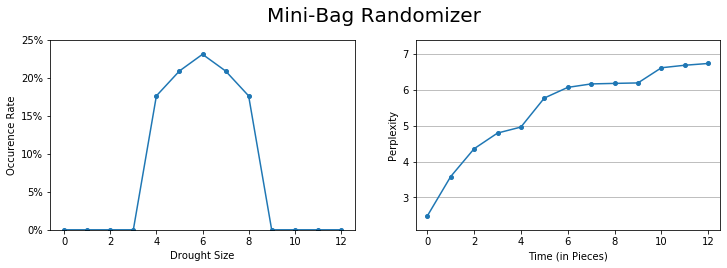

Number of randomizer states (nodes): 6
Number of state transitions (edges): 12
Sum of drought interval probabilities:  100.0 %
Entropy (Base 7):  43.55 %



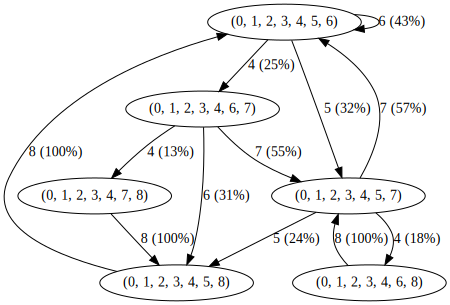

In [24]:
def plot_graph(state_graph):
    G = graphviz.Digraph()
    G.attr(size='10')
    G.attr('node', shape='oval')
    for from_node, to_node in state_graph.edges():
        G.edge(
            str(from_node),
            str(to_node),
            label=str(state_graph.edges[from_node, to_node]['drought']) + " ("
            + str(
                int(
                    round(100 * state_graph.edges[from_node, to_node]['weight']
                          ))) + "%)")
    return G


mini_bag = copy.deepcopy(Seamless_B7)
mini_bag = remove_droughts(mini_bag, [0, 1, 2, 3, 9, 10, 11, 12])
mini_bag = global_max_entropy(mini_bag)
rand_report(mini_bag, "Mini-Bag", save=True)
plot_graph(mini_bag)

Analyzing future 0 with 64 states...
Entropy: 3.262744224645478
Analyzing future 1 with 256 states...
Entropy: 4.41537926841763
Analyzing future 2 with 991 states...
Entropy: 5.310692168693936
Analyzing future 3 with 3823 states...
Entropy: 5.906230530928709
Analyzing future 4 with 14831 states...
Entropy: 6.259122131247203
Analyzing future 5 with 56369 states...
Entropy: 6.734518970641403
Analyzing future 6 with 200187 states...
Entropy: 6.88949257616095
Analyzing future 7 with 635943 states...
Entropy: 6.918469660391028
Analyzing future 8 with 1773875 states...
Entropy: 6.927660029844568


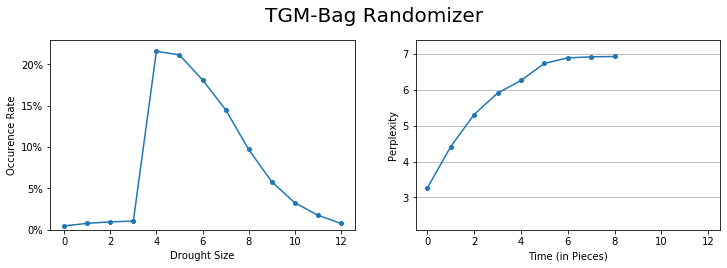

Number of randomizer states (nodes): 64
Number of state transitions (edges): 256
Sum of drought interval probabilities:  100.0 %
Entropy (Base 7):  59.72 %



In [25]:
tgm_bag = copy.deepcopy(Seamless_B7)

# give maximum entropy weights
for from_node in tgm_bag:
    denominator = 0
    for to_node in nx.neighbors(tgm_bag, from_node):
        if tgm_bag.edges[from_node, to_node]['drought'] <= 3:
            denominator += 0.01
        elif tgm_bag.edges[from_node, to_node]['drought'] <= 5:
            denominator += 1.5 * tgm_bag.edges[from_node, to_node]['weight']
        else:
            denominator += tgm_bag.edges[from_node, to_node]['weight']
    for to_node in nx.neighbors(tgm_bag, from_node):
        if tgm_bag.edges[from_node, to_node]['drought'] <= 3:
            tgm_bag.edges[from_node, to_node]['weight'] = 0.01 / denominator
        elif tgm_bag.edges[from_node, to_node]['drought'] <= 5:
            tgm_bag.edges[from_node, to_node]['weight'] = 1.5 * \
                tgm_bag.edges[from_node, to_node]['weight']/denominator
        else:
            tgm_bag.edges[from_node, to_node]['weight'] = tgm_bag.edges[
                from_node, to_node]['weight'] / denominator

rand_report(tgm_bag, "TGM-Bag", save=True)

Analyzing future 0 with 924 states...
Entropy: 4.358237486054704
Analyzing future 1 with 3696 states...
Entropy: 5.211512339633584
Analyzing future 2 with 15540 states...
Entropy: 5.868134461802868
Analyzing future 3 with 62286 states...
Entropy: 6.353416483533043
Analyzing future 4 with 239274 states...
Entropy: 6.703208393416267
Analyzing future 5 with 882301 states...
Entropy: 6.8983411708098945


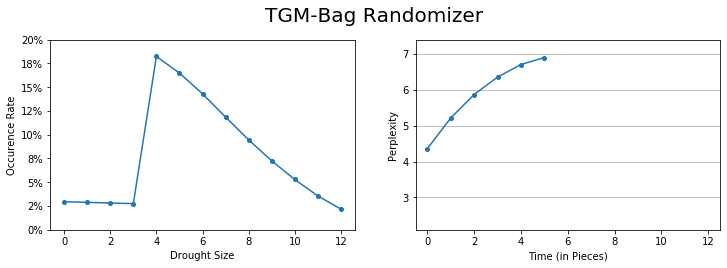

Number of randomizer states (nodes): 924
Number of state transitions (edges): 3696
Sum of drought interval probabilities:  100.0 %
Entropy (Base 7):  74.65 %



In [26]:
tgm_bag = copy.deepcopy(D12)

suppression = 0.02

# give maximum entropy weights
for from_node in tgm_bag:
    denominator = 0
    for to_node in nx.neighbors(tgm_bag, from_node):
        if tgm_bag.edges[from_node, to_node]['drought'] <= 3:
            denominator += suppression
        else:
            denominator += tgm_bag.edges[from_node, to_node]['weight']
    for to_node in nx.neighbors(tgm_bag, from_node):
        if tgm_bag.edges[from_node, to_node]['drought'] <= 3:
            tgm_bag.edges[from_node, to_node]['weight'] = suppression / denominator
        else:
            tgm_bag.edges[from_node, to_node]['weight'] = tgm_bag.edges[
                from_node, to_node]['weight'] / denominator

rand_report(tgm_bag, "TGM-Bag")

Analyzing future 0 with 924 states...
Entropy: 4.425510216782226
Analyzing future 1 with 3696 states...
Entropy: 5.29717770272018
Analyzing future 2 with 15540 states...
Entropy: 5.959764929321798
Analyzing future 3 with 62286 states...
Entropy: 6.429791190729532
Analyzing future 4 with 239274 states...
Entropy: 6.744690578870692
Analyzing future 5 with 882301 states...
Entropy: 6.911015434511998


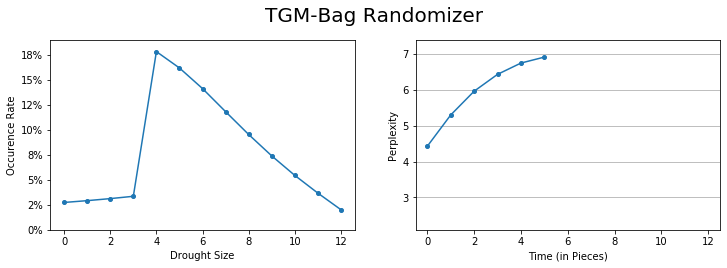

Number of randomizer states (nodes): 924
Number of state transitions (edges): 3696
Sum of drought interval probabilities:  100.0 %
Entropy (Base 7):  75.34 %



In [27]:
tgm_bag = full_graph(drought_max=12)
tgm_bag = global_max_entropy(tgm_bag)

suppression = 0.20

# give maximum entropy weights
for from_node in tgm_bag:
    denominator = 0
    for to_node in nx.neighbors(tgm_bag, from_node):
        if tgm_bag.edges[from_node, to_node]['drought'] <= 3:
            denominator += tgm_bag.edges[from_node,
                                         to_node]['weight'] * suppression
        else:
            denominator += tgm_bag.edges[from_node, to_node]['weight']
    for to_node in nx.neighbors(tgm_bag, from_node):
        if tgm_bag.edges[from_node, to_node]['drought'] <= 3:
            tgm_bag.edges[from_node, to_node]['weight'] = tgm_bag.edges[
                from_node, to_node]['weight'] * suppression / denominator
        else:
            tgm_bag.edges[from_node, to_node]['weight'] = tgm_bag.edges[
                from_node, to_node]['weight'] / denominator

rand_report(tgm_bag, "TGM-Bag")

This one should violate any sort of "all nodes could be any permutation of drought order" test.

Analyzing future 0 with 22 states...
Entropy: 5.285714285714283
Analyzing future 1 with 102 states...
Entropy: 5.285714285714283


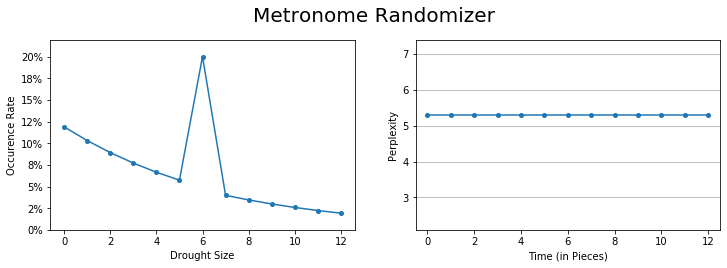

Number of randomizer states (nodes): 22
Number of state transitions (edges): 102
Sum of drought interval probabilities:  88.46 %
Entropy (Base 7):  78.92 %



In [28]:
Metronome = nx.MultiDiGraph()
state_set = set()
state_work = list()

old_state = [0, 0]
state_work.append(old_state)

while len(state_work) > 0:
    # manage work queue
    old_state = copy.deepcopy(state_work[0])
    state_work.pop(0)
    state_set.add(tuple(old_state))
    # explore state transitions
    for roll in range(7):
        new_state = copy.deepcopy(old_state)
        counter = old_state[1]
        metro_i = old_state[0]
        if roll == metro_i:
            if counter == 6:
                new_state = [0, 0]
                Metronome.add_edge(
                    tuple(old_state), tuple(new_state), pick=roll, weight=1)
            continue
        elif counter == 6:
            continue
        elif roll > metro_i:
            new_state[0] = metro_i + 1
        new_state[1] = counter + 1

        Metronome.add_edge(
            tuple(old_state), tuple(new_state), pick=roll, weight=1 / 6)
        if (tuple(new_state) not in state_set) and (
                new_state not in state_work):
            state_work.append(new_state)

rand_report(Metronome, "Metronome")

### Folding away graph symmetries

Consider the subgraph below. The node $X$ appears functionally identical to node $B$. In both cases there is a 100% probability of advancing to node $C$. Node $X$ could be eliminated with $A$ strictly pointing to node $B$ instead.

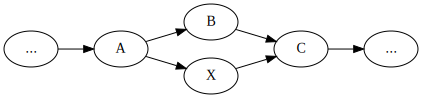

In [29]:
demo = nx.DiGraph()
demo.add_edge(" ...", "A")
demo.add_edge("A", "B")
demo.add_edge("A", "X")
demo.add_edge("B", "C")
demo.add_edge("X", "C")
demo.add_edge("C", "... ")

def plot_graph(graph):
    viz = graphviz.Digraph()
    viz.attr(rankdir='LR', size='10')
    viz.attr('node', shape='oval')
    for from_node, to_node in graph.edges():
        viz.edge(str(from_node), str(to_node))
    return viz

plot_graph(demo)

The implication here is that there may be more than one way to construct the graph of a randomizer algorithm. In the general case, these sorts of graph symmetries can be even more nuanced. Instead of individual nodes, perhaps whole clusters of nodes behave equivalently. What we need is a general method to detect these graph symmetries and fold them away into a simpler, minimal graph.

Let us define the following equivalence relation:

* A node's signature is defined to be the set of edge characteristics (ie. the tuples of each piece pick and its corresponding probability weight).
* 2 nodes are equivalent if they share the same signature and every edge's destination nodes is also equivalent.

It can be seen, by induction, that all nodes sharing an equivalence relation are functionally identical and the graph may be simplified by replacing each equivalence class with a single node. However, there is a bit of a chicken and egg problem: Since the equivalence relation is defined recursively and it is unclear how to construct an appropriate node partition.

An algorithm for creating the partition is as follows:
1. For each ${V \choose 2}$ node pairs, compare their signatures saving matches to a list.
2. Iterate over the list, comparing destination node signatures. Remove any inequalities from the list.
3. Repeat step 2 until a full pass without removing nodes is completed.

To construct the new simplified graph, it suffices to iterate over the original graph replacing any node belonging to the list of equivalence classes with a single node chosen from its equivalency class. Note that the above method omits from the list any nodes who are only equivalent to themselves.

In [30]:
def fold_graph(graph, denominator=math.factorial(12)):

    print("Scanning", len(graph), "nodes for graph symmetries...")
    graph = nx.MultiDiGraph(graph)

    # node state is potentially about to disappear, map the state to abstract numbers
    node_list = list(graph)
    node2index = dict()
    for i, node in enumerate(node_list):
        node2index[node] = i

    # find each node's signature (the set of branch picks+weights)
    node2sig = dict()
    node2dests = dict()
    for i, from_node in enumerate(node_list):
        sig = set()
        dests = [-1] * 7
        for to_node in graph[from_node]:
            for key in graph[from_node][to_node]:
                pick = graph[from_node][to_node][key]['pick']
                weight = graph[from_node][to_node][key]['weight']
                weight = int(round(weight * denominator, 0))
                dest = node2index[to_node]
                dests[pick] = dest
                sig.add((pick, weight))
        node2dests[i] = dests
        node2sig[i] = frozenset(sig)
    
    # find potential duplicates (ie. matching branch signature sets)
    dupes = set()
    for a in range(len(node_list)):
        for b in range(a + 1, len(node_list)):
            if node2sig[a] == node2sig[b]:
                dupes.add((a, b))
    dupes_changed = True

    # remove all dupes whose destination nodes have mismatched signatures
    # iterate until a full pass without changes is completed
    # whatever remains, by induction, must be true dupes
    loop = 0
    while dupes_changed == True:
        loop += 1
        distinct_dupes = set()
        for a, b in dupes:
            distinct_dupes.add(b)
        print(len(distinct_dupes), "potentially redundant nodes...")

        dupes_changed = False
        dupe_list = list(dupes)
        for a, b in dupe_list:
            for pick in range(7):
                dest_a = node2dests[a][pick]
                dest_b = node2dests[b][pick]
                if dest_a == dest_b:
                    continue
                if (dest_a, dest_b) not in dupes and (dest_b,
                                                      dest_a) not in dupes:
                    dupes.remove((a, b))
                    dupes_changed = True
                    break
    print("Confirmed.")
    
    # no dupes found -- return original graph
    if len(dupes) == 0:
        print("No symmetries detected.")
        return graph

    # create a new mapping, each node number is reduced to the lowest matching node number
    node_map = dict()
    for a, b in dupes:
        if b in node_map:
            if a < node_map[b]:
                node_map[b] = a
        else:
            node_map[b] = a

    # use the new mapping to create a simpler, symmetry-folded graph
    new_graph = nx.MultiDiGraph()
    for from_node_i in range(len(node_list)):
        if from_node_i in node_map:
            continue
        from_node = node_list[from_node_i]
        for to_node in graph[from_node]:
            to_node_i = node2index[to_node]
            if to_node_i in node_map:
                remap = node_list[node_map[to_node_i]]
            else:
                remap = to_node
            for key in graph[from_node][to_node]:
                pick = graph[from_node][to_node][key]['pick']
                weight = graph[from_node][to_node][key]['weight']
                new_graph.add_edge(from_node, remap, pick=pick, weight=weight)

    return new_graph

#### Test: Wasteful Pure Random

Here we wastefully remember the state of the last 4 pieces while constructing a pure randomizer. The wasteful version has $7^4$ nodes and $7^5$ edges, however the ideal graph is obviously 1 node with 7 edges.

Analyzing future 0 with 2401 states...
Entropy: 7.000000000000199


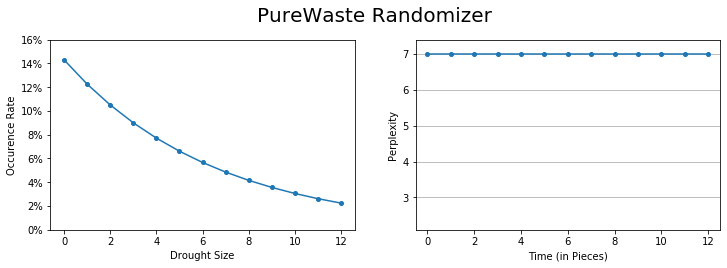

Number of randomizer states (nodes): 2401
Number of state transitions (edges): 16807
Sum of drought interval probabilities:  86.52 %
Entropy (Base 7):  100.0 %

Scanning 2401 nodes for graph symmetries...
2400 potentially redundant nodes...
Confirmed.
Analyzing future 0 with 1 states...
Entropy: 7.000000000000003


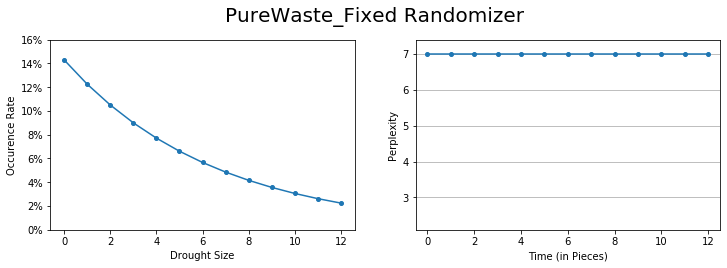

Number of randomizer states (nodes): 1
Number of state transitions (edges): 7
Sum of drought interval probabilities:  86.52 %
Entropy (Base 7):  100.0 %



In [31]:
PureWaste = nx.MultiDiGraph()
state_set = set()
state_work = list()

waste = 4
old_state = [0] * waste
state_work.append(old_state)

while len(state_work) > 0:
    # manage work queue
    old_state = copy.deepcopy(state_work[0])
    state_work.pop(0)
    state_set.add(tuple(old_state))
    # explore state transitions
    for roll in range(7):
        new_state = copy.deepcopy(old_state)
        for i in range(waste - 1):
            new_state[waste - i - 1] = new_state[waste - i - 2]
        new_state[0] = roll

        PureWaste.add_edge(
            tuple(old_state), tuple(new_state), pick=roll, weight=1 / 7)
        if (tuple(new_state) not in state_set) and (
                new_state not in state_work):
            state_work.append(new_state)

rand_report(PureWaste, "PureWaste")
PureWaste_Fixed = fold_graph(PureWaste)
rand_report(PureWaste_Fixed, "PureWaste_Fixed")

#### Test: Wasteful TGM1

Here we wastefully remember the state of the last 4 pieces while constructing the TGM1 randomizer. The wasteful version again has $7^4$ nodes and $7^5$ edges, but the ideal graph is known to have 8 nodes and $8 \times 7$ edges.

Analyzing future 0 with 2401 states...
Entropy: 4.3801273062549955
Analyzing future 1 with 16807 states...
Entropy: 5.110739858644284
Analyzing future 2 with 117649 states...
Entropy: 5.678690362163111
Analyzing future 3 with 823543 states...
Entropy: 6.107676860029984


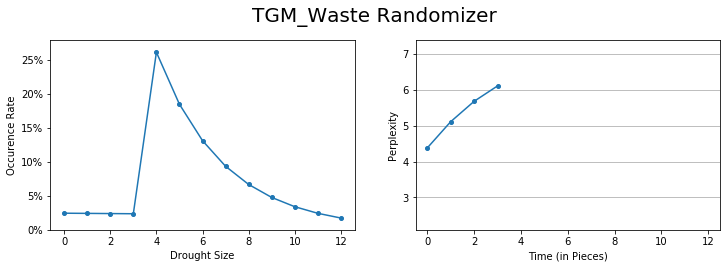

Number of randomizer states (nodes): 2401
Number of state transitions (edges): 16807
Sum of drought interval probabilities:  95.68 %
Entropy (Base 7):  75.9 %

Scanning 2401 nodes for graph symmetries...
2397 potentially redundant nodes...
2395 potentially redundant nodes...
2393 potentially redundant nodes...
Confirmed.
Analyzing future 0 with 8 states...
Entropy: 4.380127306254958
Analyzing future 1 with 56 states...
Entropy: 5.1107398586443615
Analyzing future 2 with 392 states...
Entropy: 5.678690362163095
Analyzing future 3 with 2408 states...
Entropy: 6.107676860030065
Analyzing future 4 with 12824 states...
Entropy: 6.43012846112695
Analyzing future 5 with 45696 states...
Entropy: 6.859553690347216
Analyzing future 6 with 122640 states...
Entropy: 6.918222737905065
Analyzing future 7 with 228480 states...
Entropy: 6.921487637010338
Analyzing future 8 with 302400 states...
Entropy: 6.941404902176026
Analyzing future 9 with 322560 states...
Entropy: 6.986243007702734
Analyzing fut

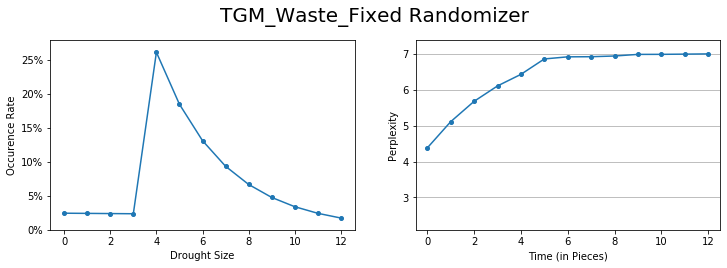

Number of randomizer states (nodes): 8
Number of state transitions (edges): 56
Sum of drought interval probabilities:  95.68 %
Entropy (Base 7):  75.9 %



In [32]:
TGM_Waste = nx.MultiDiGraph()
state_set = set()
state_work = list()

old_state = [0, 0, 0, 0]
state_work.append(old_state)

while len(state_work) > 0:
    # manage work queue
    old_state = copy.deepcopy(state_work[0])
    state_work.pop(0)
    state_set.add(tuple(old_state))
    # explore state transitions
    for pick in range(7):
        new_state = copy.deepcopy(old_state)
        n_distinct = len(set(old_state))
        picks = []
        for i in old_state:
            if i not in picks:
                picks.append(i)
        for i in range(7):
            if i not in picks:
                picks.append(i)
        # shuffle history down
        for i in range(4 - 1):
            new_state[4 - i - 1] = new_state[4 - i - 2]
        new_state[0] = picks[pick]
        weight = (n_distinct / 7)**4
        if pick < n_distinct:
            weight = weight / n_distinct
        else:
            weight = 1 - weight
            weight = weight / (7 - n_distinct)

        TGM_Waste.add_edge(
            tuple(old_state), tuple(new_state), pick=pick, weight=weight)
        if (tuple(new_state) not in state_set) and (
                new_state not in state_work):
            state_work.append(new_state)

rand_report(TGM_Waste, "TGM_Waste")
TGM_Waste_Fixed = fold_graph(TGM_Waste)
rand_report(TGM_Waste_Fixed, "TGM_Waste_Fixed")

#### Test: Wasteful 7-bag
Here we wastefully remember the running total drought vector of the 7 pieces. The wasteful version 127 and 448 edges, but the ideal graph is known to have 7 nodes and 28 edges.

Analyzing future 0 with 127 states...
Entropy: 4.000000000000004
Analyzing future 1 with 448 states...
Entropy: 4.857142857142861
Analyzing future 2 with 1393 states...
Entropy: 5.571428571428578
Analyzing future 3 with 3948 states...
Entropy: 6.142857142857144
Analyzing future 4 with 11382 states...
Entropy: 6.571428571428551
Analyzing future 5 with 38220 states...
Entropy: 6.857142857142832
Analyzing future 6 with 141330 states...
Entropy: 6.9999999999999725


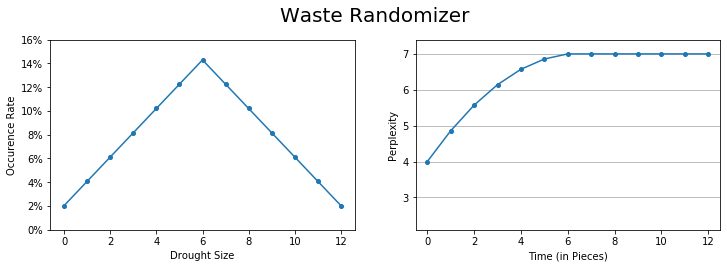

Number of randomizer states (nodes): 127
Number of state transitions (edges): 448
Sum of drought interval probabilities:  100.0 %
Entropy (Base 7):  62.59 %

Scanning 127 nodes for graph symmetries...
120 potentially redundant nodes...
Confirmed.
Analyzing future 0 with 7 states...
Entropy: 3.999999999999999
Analyzing future 1 with 28 states...
Entropy: 4.857142857142858
Analyzing future 2 with 119 states...
Entropy: 5.571428571428572
Analyzing future 3 with 474 states...
Entropy: 6.142857142857143
Analyzing future 4 with 1646 states...
Entropy: 6.571428571428568
Analyzing future 5 with 4692 states...
Entropy: 6.857142857142848
Analyzing future 6 with 10350 states...
Entropy: 6.999999999999983


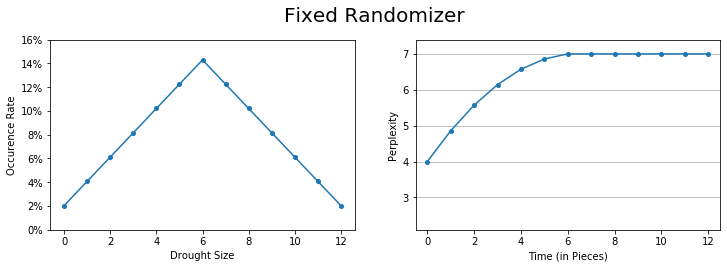

Number of randomizer states (nodes): 7
Number of state transitions (edges): 28
Sum of drought interval probabilities:  100.0 %
Entropy (Base 7):  62.59 %



In [33]:
G = B7

rand_report(G, "Waste")
Fixed = fold_graph(G)
rand_report(Fixed, "Fixed")

Scanning 127 nodes for graph symmetries...
120 potentially redundant nodes...
Confirmed.
7 Periodic Components
Randomizer State: {'bag_index': 0, 'droughts': [0, 1, 2, 3, 4, 5, 6]} : 0
Randomizer State: {'bag_index': 1, 'droughts': [0, 2, 3, 4, 5, 6, 7]} : 1
Randomizer State: {'bag_index': 2, 'droughts': [0, 1, 4, 5, 6, 7, 8]} : 2
Randomizer State: {'bag_index': 3, 'droughts': [0, 1, 2, 6, 7, 8, 9]} : 3
Randomizer State: {'bag_index': 4, 'droughts': [0, 1, 2, 3, 8, 9, 10]} : 4
Randomizer State: {'bag_index': 5, 'droughts': [0, 1, 2, 3, 4, 10, 11]} : 5
Randomizer State: {'bag_index': 6, 'droughts': [0, 1, 2, 3, 4, 5, 12]} : 6
Analyzing future 0 with 7 states...
Entropy: 4.000000000000002
Analyzing future 1 with 28 states...
Entropy: 4.8571428571428585
Analyzing future 2 with 119 states...
Entropy: 5.571428571428573
Analyzing future 3 with 474 states...
Entropy: 6.142857142857142
Analyzing future 4 with 1646 states...
Entropy: 6.571428571428567
Analyzing future 5 with 4692 states...
Entr

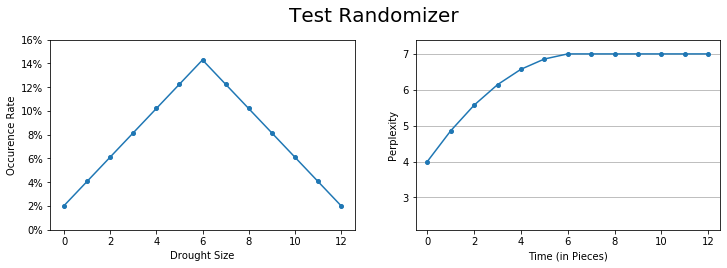

Number of randomizer states (nodes): 7
Number of state transitions (edges): 28
Sum of drought interval probabilities:  100.0 %
Entropy (Base 7):  62.59 %



In [34]:
G = B7
G = fold_graph(G)

from math import gcd

s = next(iter(G))
levels = {s: 0}
this_level = [s]
g = 0
lev = 1
while this_level:
    next_level = []
    for u in this_level:
        for v in G[u]:
            if v in levels:  # Non-Tree Edge
                g = gcd(g, levels[u] - levels[v] + 1)
            else:  # Tree Edge
                next_level.append(v)
                levels[v] = lev
    this_level = next_level
    lev += 1

for v, lev in levels.items():
    levels[v] = lev % g
    
print(g, "Periodic Components")
if g > 1:
    for s, level in levels.items():
        print(s, ":", level)
    
rand_report(G, "Test")

Scanning 22 nodes for graph symmetries...
10 potentially redundant nodes...
6 potentially redundant nodes...
1 potentially redundant nodes...
0 potentially redundant nodes...
Confirmed.
No symmetries detected.

2 Permutation Components
0 : {0}
1 : {1, 2, 3, 4, 5, 6}
2 : {1, 2, 3, 4, 5, 6}
3 : {1, 2, 3, 4, 5, 6}
4 : {1, 2, 3, 4, 5, 6}
5 : {1, 2, 3, 4, 5, 6}
6 : {1, 2, 3, 4, 5, 6}

7 Periodic Components
(0, 0) : 0
(1, 1) : 1
(1, 2) : 2
(2, 2) : 2
(1, 3) : 3
(2, 3) : 3
(3, 3) : 3
(1, 4) : 4
(2, 4) : 4
(3, 4) : 4
(4, 4) : 4
(1, 5) : 5
(2, 5) : 5
(3, 5) : 5
(4, 5) : 5
(5, 5) : 5
(1, 6) : 6
(2, 6) : 6
(3, 6) : 6
(4, 6) : 6
(5, 6) : 6
(6, 6) : 6
Analyzing future 0 with 22 states...
Entropy: 5.2857142857142865
Analyzing future 1 with 102 states...
Entropy: 5.285714285714285


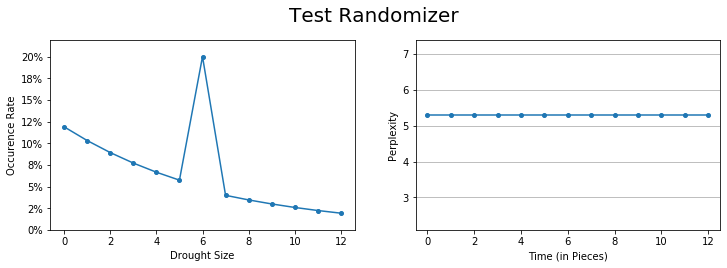

Number of randomizer states (nodes): 22
Number of state transitions (edges): 102
Sum of drought interval probabilities:  88.46 %
Entropy (Base 7):  78.92 %



In [35]:
G = Metronome
G = fold_graph(G)

from math import gcd

s = next(iter(G))
map = list(range(7))
levels = {s: 0}
mappings = {s: map}
permutation_groups = dict()
for i in range(7):
    permutation_groups[i] = set([i])
    
this_level = [s]
g = 0
lev = 1
while this_level:
    next_level = []
    for u in this_level:
        for v in G[u]:
            for key in G[u][v]:

                # update map based on pick
                map = copy.deepcopy(mappings[u])
                pick = G[u][v][key]['pick']
                orig_pick = map[pick]
                for i in reversed(range(pick)):
                    map[i+1] = map[i]
                map[0] = orig_pick
                
                if v in levels:  # Non-Tree Edge
                    g = gcd(g, levels[u] - levels[v] + 1)
                    for i in range(7):
                        old_group = permutation_groups[mappings[v][i]]
                        curr_group = permutation_groups[map[i]]
                        # expand permutation groups
                        if old_group != curr_group:
                            new_group = old_group.union(curr_group)
                            for p in new_group:
                                permutation_groups[p] = new_group
                else:  # Tree Edge
                    next_level.append(v)
                    levels[v] = lev
                    mappings[v] = map
    this_level = next_level
    lev += 1

for v, lev in levels.items():
    levels[v] = lev % g

for slot, group in permutation_groups.items():
    permutation_groups[slot] = frozenset(group)
pg = len(set(permutation_groups.values()))

print()
print(pg, "Permutation Components")
if pg > 1:
    for slot, group in permutation_groups.items():
        print(slot, ":", set(group))

print()
print(g, "Periodic Components")
if g > 1:
    for s, level in levels.items():
        print(s, ":", level)
    
rand_report(G, "Test")